In [1]:
import re
import json

In [3]:
with open('data/Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('data/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 21239

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
23     2649170        21239               30   
28     2701211        21239               30   
41     2569676        21239               30   
45     2359074        21239               30   
50     1917843        21239               30   

                                                title  year  \
23  Computed tomography image source identificatio...  2015   
28  Restoration of vision using wireless cortical ...  2015   
41  Optical flow with structure information for ep...  2015   
45            CBIT - context-based image transmission  2001   
50  Compression guidelines for diagnostic telepath...  1997   

                                             abstract  
23  In this paper, we focus on the identification ...  
28  Monash Vision Group is developing a bionic vis...  
41  Mosaicing of biological tissue surfaces is cha...  
45  Few networks offer sufficient bandwidth for th...  
50  As the healthcare community has begun to rely ...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

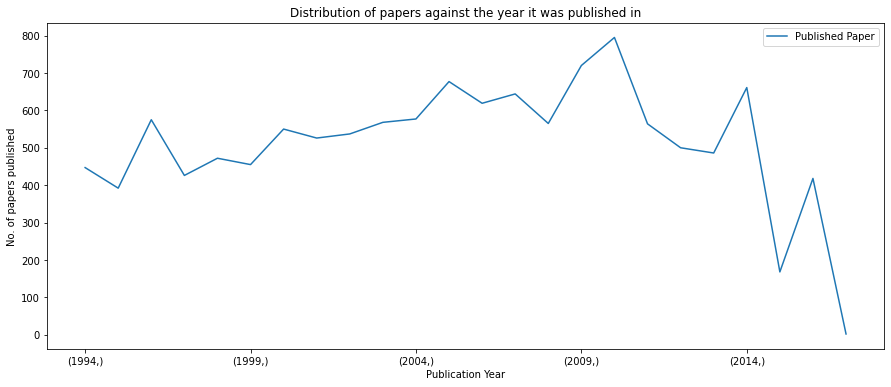

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2008 with year 2013 accounting for the highest number of papers.

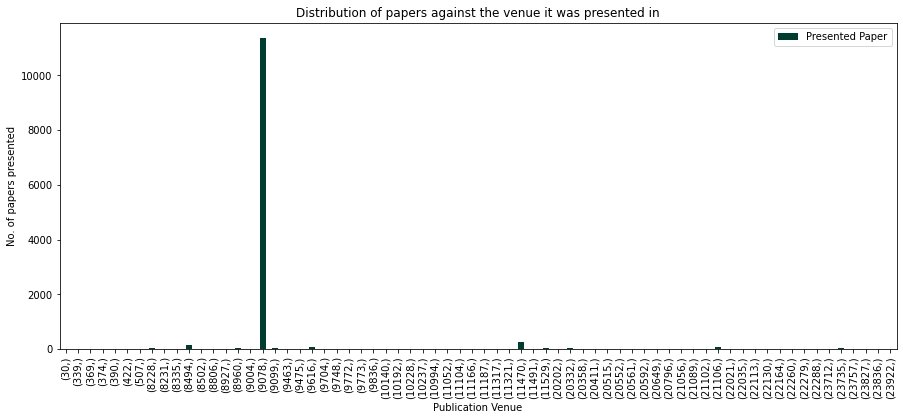

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [13]:
conference_data_dict[9078]

'international conference on image processing'

One interesting thing we can note here is that most papers of the community were presented at the same venue. The venue_id where majority of the papers were presented is 9078 which corresponds to the **International Conference on Image Processing**, Hence most of the papers in the community are from that conference. We should be expecting papers about image processing and computer vision.

In [14]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

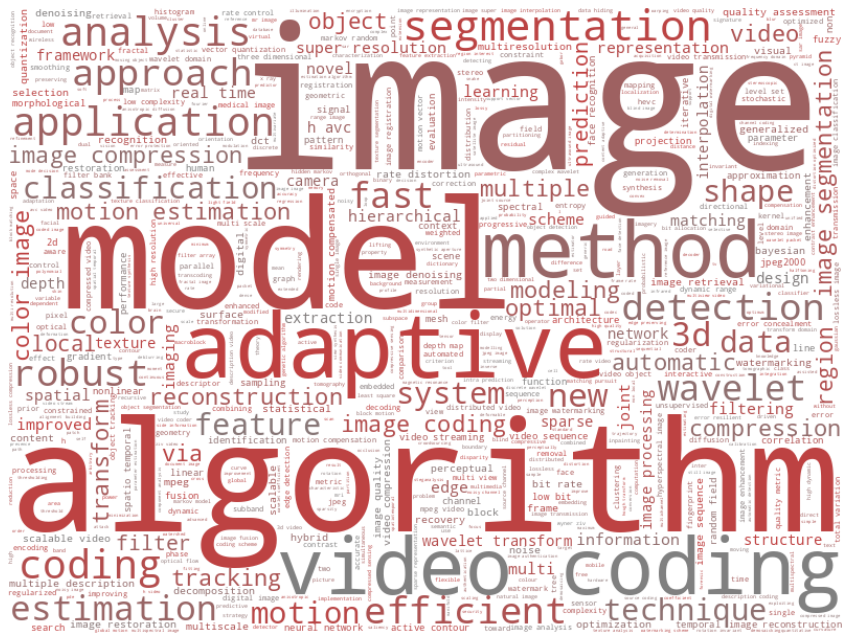

In [15]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the [wordcloud](https://boostlabs.com/blog/what-are-word-clouds-value-simple-visualizations/), we can see that a lot of papers of the community focus on images and videos models and algorithms. Since most papers of the community were presented at a conference about image processing, the results definitely are what we expect it to be like. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

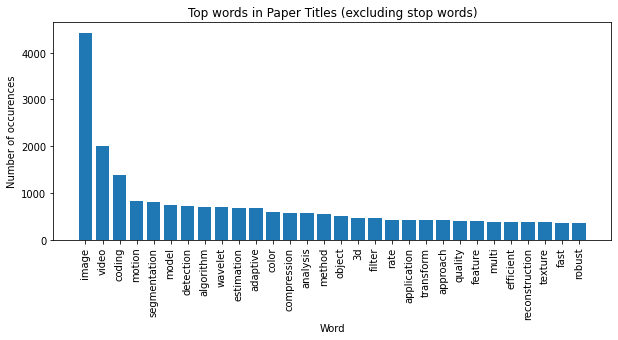

In [16]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are image, video, motion and so on. Considering most papers are about remote sensing and geo spatial data, the results are consistent.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [17]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [18]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [19]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [20]:
lda.show_topics(total_topics,6)

[(0,
  '0.027*"image" + 0.027*"analysis" + 0.021*"data" + 0.021*"detection" + 0.016*"face" + 0.014*"recognition"'),
 (1,
  '0.044*"image" + 0.040*"quality" + 0.026*"assessment" + 0.024*"crowdsourcing" + 0.019*"video" + 0.015*"model"'),
 (2,
  '0.055*"video" + 0.034*"coding" + 0.027*"rate" + 0.022*"detection" + 0.016*"multiple" + 0.015*"bit"'),
 (3,
  '0.057*"image" + 0.017*"field" + 0.016*"coding" + 0.015*"network" + 0.013*"compression" + 0.012*"multi"'),
 (4,
  '0.085*"image" + 0.026*"color" + 0.016*"segmentation" + 0.016*"noise" + 0.016*"local" + 0.016*"enhancement"'),
 (5,
  '0.051*"error" + 0.032*"image" + 0.023*"video" + 0.016*"dimensional" + 0.015*"concealment" + 0.013*"reduction"'),
 (6,
  '0.037*"image" + 0.027*"model" + 0.025*"motion" + 0.021*"temporal" + 0.015*"framework" + 0.013*"markov"'),
 (7,
  '0.095*"image" + 0.025*"wavelet" + 0.021*"watermarking" + 0.020*"digital" + 0.018*"method" + 0.014*"algorithm"'),
 (8,
  '0.088*"video" + 0.056*"coding" + 0.022*"scalable" + 0.020*

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [21]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

image  analysis      data  detection      face  recognition     human  \
0  0.026688  0.026538  0.020924   0.020658  0.016429     0.014012  0.013945   
1  0.043773  0.000000  0.000000   0.000000  0.000000     0.000000  0.000000   
2  0.009193  0.009068  0.000000   0.022467  0.000000     0.000000  0.000000   
3  0.057224  0.000000  0.000000   0.000000  0.000000     0.000000  0.000000   
4  0.084732  0.000000  0.000000   0.007249  0.000000     0.000000  0.000000   
5  0.032207  0.000000  0.000000   0.000000  0.000000     0.000000  0.000000   
6  0.037348  0.007446  0.000000   0.000000  0.000000     0.000000  0.000000   
7  0.095088  0.000000  0.000000   0.010293  0.000000     0.000000  0.000000   
8  0.013388  0.000000  0.000000   0.000000  0.000000     0.000000  0.000000   
9  0.034578  0.006802  0.000000   0.000000  0.000000     0.000000  0.000000   

      shape    vision   texture  ...      high  quantization   dynamic  \
0  0.011478  0.011188  0.010840  ...  0.000000      0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000      0.000000  0.000000   
2  0.000000  0.000000  0.000000  ...  0.000000      0.000000  0.000000   
3  0.000000  0.000000  0.007330  ...  0.000000      0.000000  0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000      0.000000  0.000000   
5  0.000000  0.000000  0.000000  ...  0.000000      0.000000  0.000000   
6  0.007357  0.000000  0.009263  ...  0.000000      0.000000  0.000000   
7  0.000000  0.000000  0.000000  ...  0.000000      0.000000  0.000000   
8  0.000000  0.000000  0.000000  ...  0.000000      0.000000  0.000000   
9  0.000000  0.000000  0.000000  ...  0.017029      0.016141  0.014105   

   tracking   towards     range  template    visual   pursuit  particle  
0  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
4  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
5  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
6  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
7  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
8  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000  
9  0.013983  0.013836  0.013714   0.01205  0.011452  0.009101  0.007119  

[10 rows x 169 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


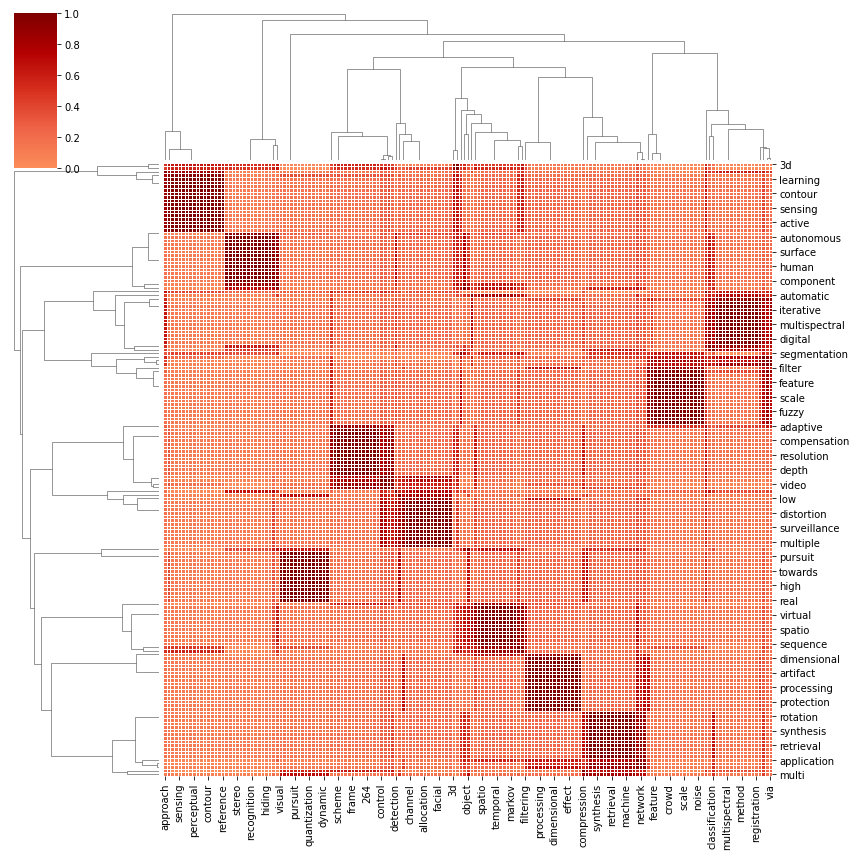

In [22]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [23]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  31.118743
3       0.648955  71.707100       2        1  24.958154
9      71.019684   9.971006       3        1   6.759933
6       3.785981  33.185135       4        1   6.582733
8     -42.666500  -9.222070       5        1   5.445280
4      -3.621689 -43.526516       6        1   5.038161
1      -3.632402  -4.171708       7        1   5.025989
0     -36.584400  35.804413       8        1   5.024046
2      44.391380  50.615383       9        1   5.023577
5      40.235809 -31.591665      10        1   5.023383, topic_info=        Term        Freq       Total Category  logprob  loglift
58     video  183.000000  183.000000  Default  30.0000  30.0000
4      image  731.000000  731.000000  Default  29.0000  29.0000
54    coding  138.000000  138.000000  Default  28.0000  28.0000
220    error   37.000000   37.000000  Default  27.0000  27.0000
199  quality   46.000000   46.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
334   mobile    4.690840   37.182350  Topic10  -4.8842   0.9208
56    scheme    4.181303   28.033322  Topic10  -4.9992   1.0883
60   network    4.494611   64.776416  Topic10  -4.9270   0.3230
136   motion    4.394428   59.868859  Topic10  -4.9495   0.3792
122  wavelet    4.300527  135.336803  Topic10  -4.9711  -0.4580

[697 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1957      8  0.660451        '
2248      2  0.993286        0
526       1  0.156419        2
526       2  0.156419        2
526       5  0.078210        2
...     ...       ...      ...
689       9  0.607808  without
203       7  0.665239   worker
62        1  0.989633    wyner
63        1  0.989635      ziv
3235      9  0.739719     zoom

[1324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 10, 7, 9, 5, 2, 1, 3, 6])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [24]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [25]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [26]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  wireless, network, lifting, resilient, streaming, video, multimedia, transmission, packet, flexible, completion, communication, cross, access, internet

Paper Titles:
Optimized transmission of H.26L/JVT coded video over packet-lossy networks
Resource Allocation for Downlink Multiuser Video Transmission Over Wireless Lossy Networks
H.26L/JVT coding network abstraction layer and IP-based transport
Flexible interchange of coded multimedia facilitating access and streaming

****************************************************************************************************
TOPIC 1:
Top Words:  image, color, wavelet, model, segmentation, denoising, detection, transform, algorithm, bayesian, tree, method, feature, estimation, classification

Paper Titles:
Sparse adaptive template matching and filtering for 2D seismic images with dual-tree wavelets and proximal methods
SSSC-AM: A unified framework for video co-segmentation by structured sparse subspace clustering with app

## Analyzing the abstracts of the papers

In [27]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

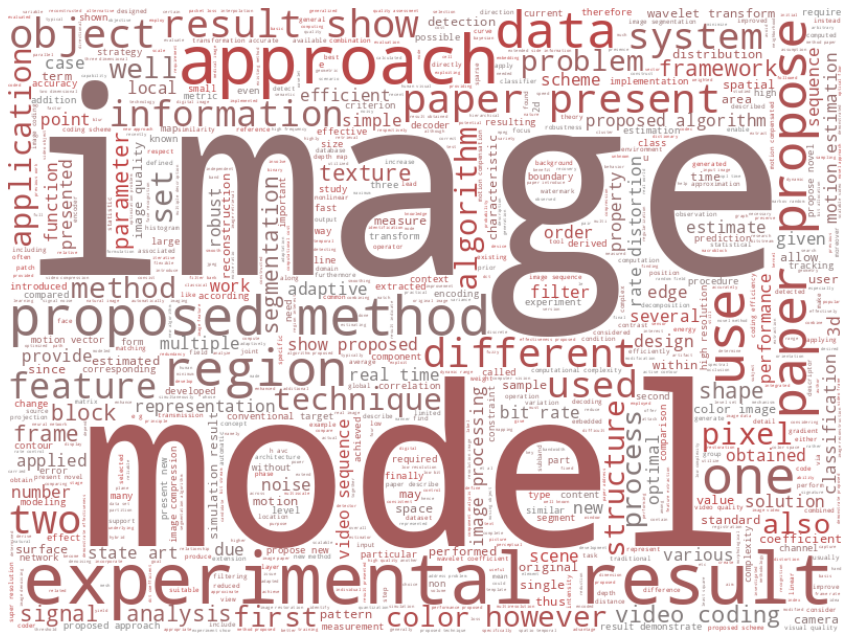

In [28]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [29]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [30]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [31]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [32]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [33]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [34]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [35]:
lda.show_topics(total_topics, 7)

[(0,
  '0.015*"video" + 0.014*"image" + 0.010*"system" + 0.008*"data" + 0.006*"algorithm" + 0.006*"model" + 0.005*"technique"'),
 (1,
  '0.018*"worker" + 0.008*"task" + 0.007*"classification" + 0.006*"image" + 0.006*"color" + 0.005*"algorithm" + 0.005*"proposed"'),
 (2,
  '0.018*"object" + 0.016*"image" + 0.011*"camera" + 0.008*"feature" + 0.008*"descriptor" + 0.006*"model" + 0.005*"method"'),
 (3,
  '0.019*"depth" + 0.006*"algorithm" + 0.006*"color" + 0.005*"image" + 0.005*"stereo image" + 0.005*"stereo" + 0.005*"transform"'),
 (4,
  '0.006*"metric" + 0.005*"reduced reference" + 0.005*"judgment" + 0.005*"assessment iqa" + 0.004*"image" + 0.004*"iqa" + 0.003*"aimed"'),
 (5,
  '0.012*"image" + 0.008*"algorithm" + 0.008*"model" + 0.005*"approach" + 0.005*"method" + 0.005*"problem" + 0.004*"convex"'),
 (6,
  '0.034*"image" + 0.020*"method" + 0.011*"model" + 0.006*"feature" + 0.006*"approach" + 0.006*"proposed" + 0.005*"algorithm"'),
 (7,
  '0.019*"image" + 0.015*"algorithm" + 0.011*"metho

In [36]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

video     image    system      data  algorithm     model  technique  \
0  0.015372  0.013912  0.010353  0.007863   0.005595  0.005590   0.005437   
1  0.004708  0.006232  0.004892  0.002564   0.005034  0.003845   0.000000   
2  0.000000  0.015699  0.002677  0.000000   0.003882  0.006368   0.000000   
3  0.000000  0.005366  0.000000  0.000000   0.006084  0.000000   0.000000   
4  0.000000  0.004298  0.000000  0.000000   0.002583  0.002246   0.000000   
5  0.000000  0.012398  0.000000  0.000000   0.007874  0.007835   0.000000   
6  0.000000  0.034418  0.004316  0.004026   0.005250  0.011241   0.004191   
7  0.000000  0.019465  0.000000  0.003054   0.014769  0.007000   0.004275   
8  0.000000  0.009568  0.000000  0.000000   0.004001  0.014512   0.000000   
9  0.003259  0.000000  0.004786  0.000000   0.002201  0.000000   0.000000   

      frame    scheme   problem  ...  multiplexing  directional filtering  \
0  0.005015  0.004989  0.004446  ...      0.000000                0.00000   
1  0.000000  0.000000  0.000000  ...      0.000000                0.00000   
2  0.000000  0.000000  0.000000  ...      0.000000                0.00000   
3  0.000000  0.000000  0.000000  ...      0.000000                0.00000   
4  0.000000  0.000000  0.000000  ...      0.000000                0.00000   
5  0.000000  0.000000  0.004652  ...      0.000000                0.00000   
6  0.000000  0.000000  0.000000  ...      0.000000                0.00000   
7  0.000000  0.004695  0.003767  ...      0.000000                0.00000   
8  0.000000  0.000000  0.000000  ...      0.000000                0.00000   
9  0.000000  0.000000  0.000000  ...      0.002391                0.00239   

   crowdsourcing system  fingerprinting        mc    client    server  \
0              0.000000        0.000000  0.000000  0.000000  0.000000   
1              0.000000        0.000000  0.000000  0.000000  0.000000   
2              0.000000        0.000000  0.000000  0.000000  0.000000   
3              0.000000        0.000000  0.000000  0.000000  0.000000   
4              0.000000        0.000000  0.000000  0.000000  0.000000   
5              0.000000        0.000000  0.000000  0.000000  0.000000   
6              0.000000        0.000000  0.000000  0.000000  0.000000   
7              0.000000        0.000000  0.000000  0.000000  0.000000   
8              0.000000        0.000000  0.000000  0.000000  0.000000   
9              0.002361        0.002323  0.002317  0.002305  0.002223   

    message      clue  newly developed  
0  0.000000  0.000000         0.000000  
1  0.000000  0.000000         0.000000  
2  0.000000  0.000000         0.000000  
3  0.000000  0.000000         0.000000  
4  0.000000  0.000000         0.000000  
5  0.000000  0.000000         0.000000  
6  0.000000  0.000000         0.000000  
7  0.000000  0.000000         0.000000  
8  0.000000  0.000000         0.000000  
9  0.002145  0.002127         0.002122  

[10 rows x 148 columns]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



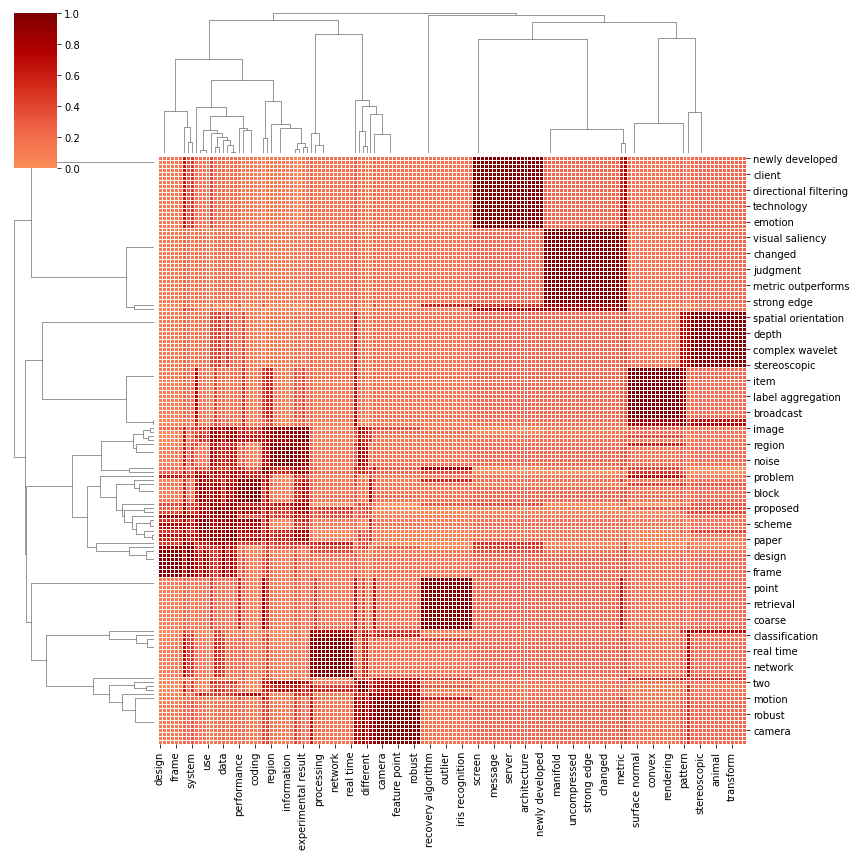

In [37]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [38]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  18.801657
6       0.648955  71.707100       2        1  15.284639
1      71.019684   9.971006       3        1  15.072777
0       3.785981  33.185135       4        1  10.409831
7     -42.666500  -9.222070       5        1   8.988862
2      -3.621689 -43.526516       6        1   6.309489
5      -3.632402  -4.171708       7        1   6.292273
3     -36.584400  35.804413       8        1   6.281739
9      44.391380  50.615383       9        1   6.281416
4      40.235809 -31.591665      10        1   6.277316, topic_info=           Term        Freq       Total Category  logprob  loglift
1328     worker   34.000000   34.000000  Default  30.0000  30.0000
4239      depth   17.000000   17.000000  Default  29.0000  29.0000
19        image  169.000000  169.000000  Default  28.0000  28.0000
601      object   30.000000   30.000000  Default  27.0000  27.0000
476       video   41.000000   41.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
86    algorithm    2.001386   69.700051  Topic10  -5.9589  -0.7821
147      method    1.912409   84.650767  Topic10  -6.0043  -1.0219
23        model    1.740041   91.851103  Topic10  -6.0988  -1.1980
113     surface    1.499571    7.627463  Topic10  -6.2475   1.1417
13      feature    1.601151   41.667799  Topic10  -6.1820  -0.4908

[719 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
10195      1  1.090424                 1 1
19359      7  1.194210                1991
4037       1  0.950909                1998
22427      8  1.166113               2 spl
25529      1  1.159084                 200
...      ...       ...                 ...
1329       3  1.169811  worker reliability
7027       1  1.004848            workflow
14006      9  1.129151             writing
19326      3  1.196870             yielded
4669       1  1.164455                zoom

[1064 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 2, 1, 8, 3, 6, 4, 10, 5])

In [39]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [40]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [41]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  verb, vase, broke, curve group, broke vase, sally broke, sally, sally broke vase, cpp, cpps, pcpg, tlti, base mdc, pn, mdc scheme description

Paper Titles:
The VerbCorner Project: Findings from Phase 1 of crowd-sourcing a semantic decomposition of verbs
An interactive method for curve extraction
A non-parametric statistics based method for generic curve partition and classification
MPEG PTY-Marks: Cheap Detection of Embedded Copyright Data in DVD-Video

****************************************************************************************************
TOPIC 1:
Top Words:  d3, d3 visualization, laser cleaning, postcard, censored, wrapped cauchy, analyte, reference implementation, restyling, dermal, genetic feature, wanets, bose, mi wrapped, von mi wrapped

Paper Titles:
Deconstructing and restyling D3 visualizations
Can modern technologies defeat nazi censorship
SQUARE: A Benchmark for Research on Computing Crowd Consensus
Automated colorimetric analysis in paper 

In [42]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [43]:
representative_df.to_csv("CSV_files/repr_21239.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
104601     2619383        21239            21089   
48629      1410820        21239             9078   
49574      1095010        21239             9078   
9868        567276        21239              374   
40767      2872071        21239             9078   
...            ...          ...              ...   
40706      2922270        21239             9078   
27595      1774525        21239             8494   
40762      2845728        21239             9078   
40715      2906730        21239             9078   
46172      2000555        21239             9078   

                                                    title  year  \
104601  The VerbCorner Project: Findings from Phase 1 ...  2014   
48629          An interactive method for curve extraction  2010   
49574   A non-parametric statistics based method for g...  2010   
9868    MPEG PTY-Marks: Cheap Detection of Embedded Co...  1998   
40767   Automated prediction of crater degradation degree  2016   
...                                                   ...   ...   
40706   Optimizing block-coded motion parameters with ...  2016   
27595   Local computation and estimation of wavelet co...  2008   
40762   Constant-time bilateral filter using spectral ...  2016   
40715   Dehazing of color image using stochastic enhan...  2016   
46172   Implementation and application of local comput...  2009   

                                                 abstract  
104601  Any given verb can appear in some syntactic fr...  
48629   We introduce a curve process framework to solv...  
49574   Generic shape feature extraction is a challeng...  
9868    In this paper we propose a method to watermark...  
40767   A learning system that is able to predict the ...  
...                                                   ...  
40706   We address the problem of optimizing block-cod...  
27595   The dual-tree complex wavelet transform (DT CW...  
40762   This paper presents an efficient constant-time...  
40715   Images captured in presence of fog, haze or sn...  
46172   The dual-tree complex wavelet transform (DT CW...  

[952 rows x 6 columns]